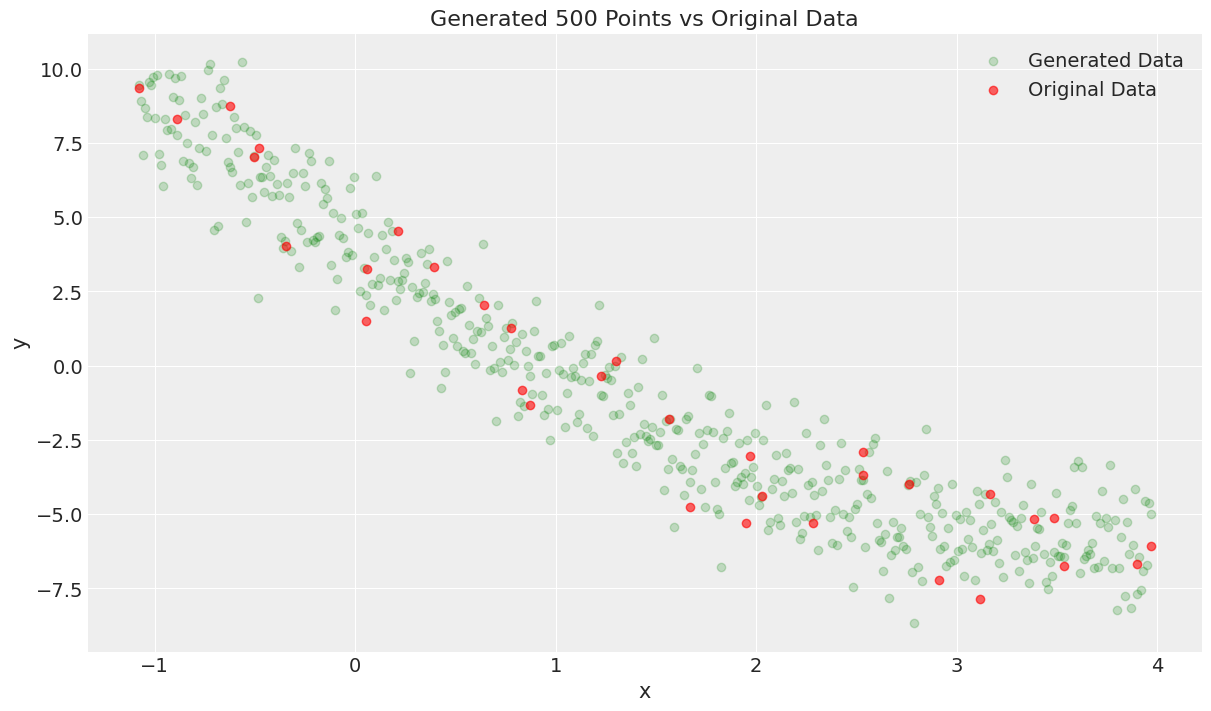

Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Fitting model with sd=10...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Output()

Sampling 4 chains for 1_000 tune and 20 draw iterations (4_000 + 80 draws total) took 124 seconds.
The number of samples is too small to check convergence reliably.


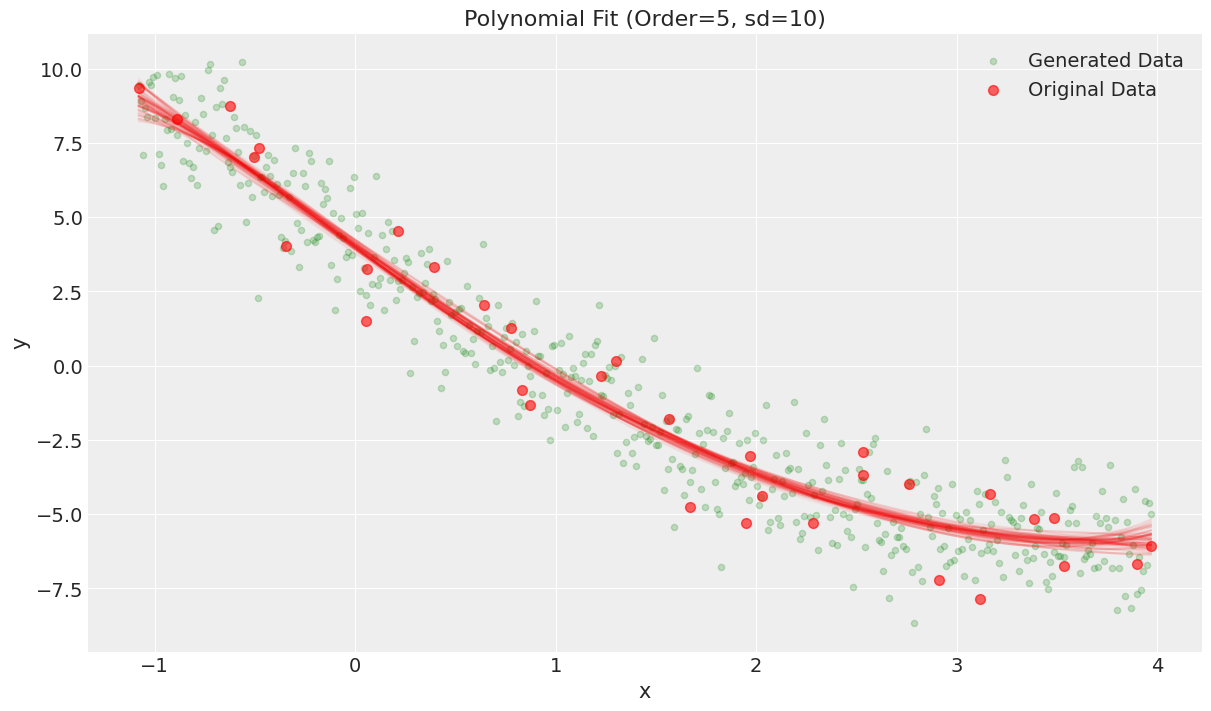

Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.



Fitting model with sd=100...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Output()

Sampling 4 chains for 1_000 tune and 20 draw iterations (4_000 + 80 draws total) took 123 seconds.
The number of samples is too small to check convergence reliably.


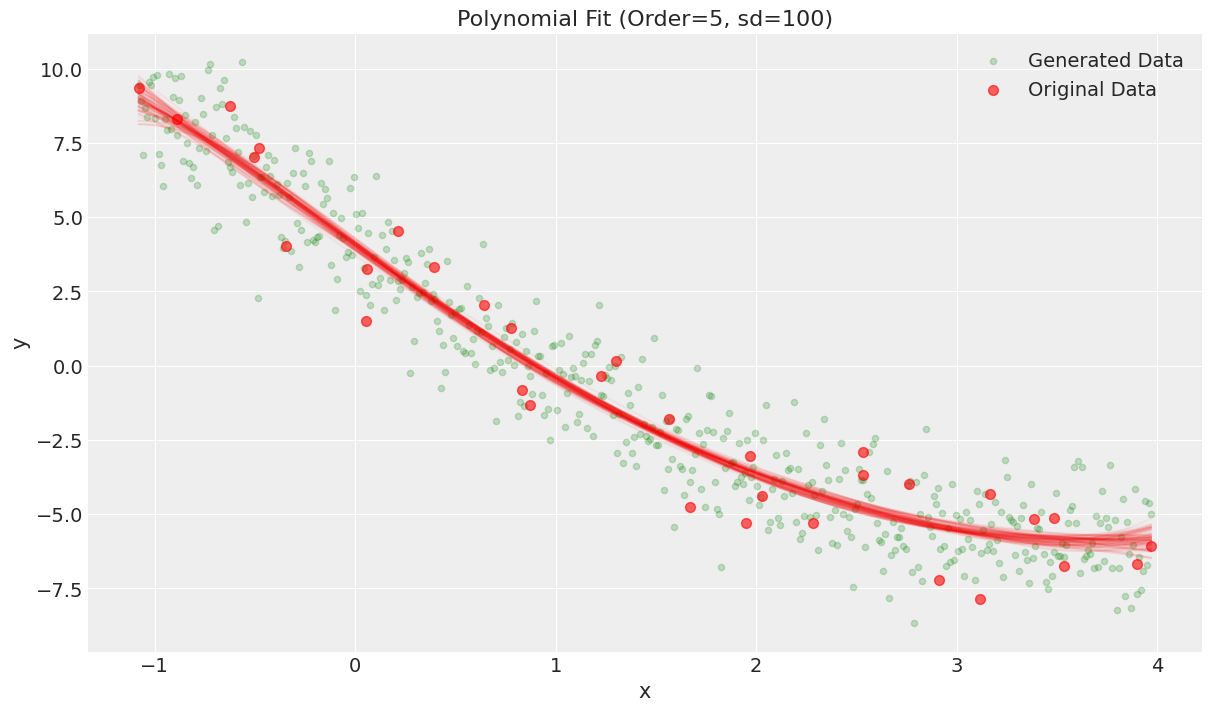

Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.



Fitting model with varying sd...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Output()

Sampling 4 chains for 1_000 tune and 20 draw iterations (4_000 + 80 draws total) took 37 seconds.
The number of samples is too small to check convergence reliably.


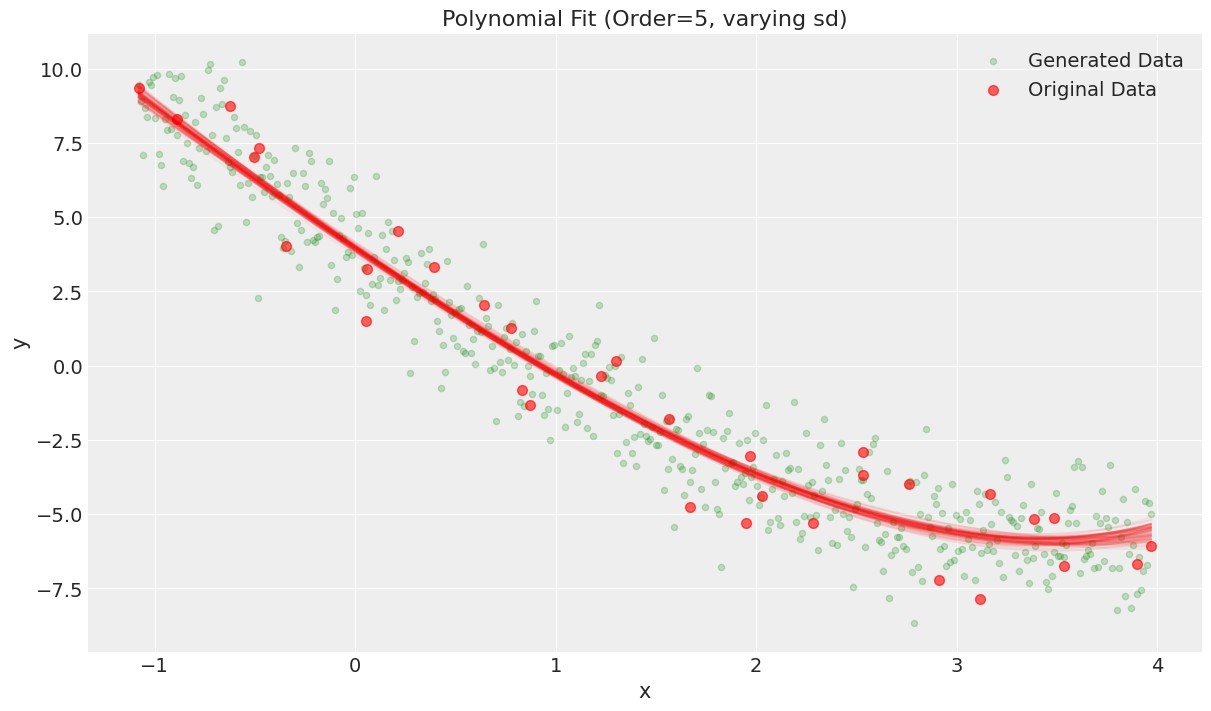

In [19]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
from scipy.stats import norm

# Load original data
data = np.loadtxt('date.csv')
x_orig = data[:, 0]
y_orig = data[:, 1]


def generate_500_points(x_orig, y_orig):
    # Generate evenly spaced x points
    x_new = np.linspace(x_orig.min(), x_orig.max(), 500)

    # Fit a polynomial to get the general trend (using numpy's polyfit)
    coeffs = np.polyfit(x_orig, y_orig, 5)
    y_trend = np.polyval(coeffs, x_orig)

    # Calculate residual standard deviation from original data
    residuals = y_orig - y_trend
    noise_std = np.std(residuals)

    # Generate y values using the same polynomial plus appropriate noise
    y_new_trend = np.polyval(coeffs, x_new)
    y_new = y_new_trend + np.random.normal(0, noise_std, size=500)

    return x_new, y_new


# Generate the 500 points
x_1, y_1 = generate_500_points(x_orig, y_orig)


def create_polynomial_features(x, order):
    x_1p = np.vstack([x ** i for i in range(1, order + 1)])
    x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)
    return x_1s.T


def fit_polynomial(x, y, order, beta_sd):
    x_1s = create_polynomial_features(x, order)
    y_1s = (y - y.mean()) / y.std()

    with pm.Model() as model_p:
        # Priors
        α = pm.Normal('α', mu=0, sigma=1)
        β = pm.Normal('β', mu=0, sigma=beta_sd, shape=order)
        ε = pm.HalfNormal('ε', 5)

        # Model
        μ = α + pm.math.dot(x_1s, β)
        y_pred = pm.Normal('y_pred', mu=μ, sigma=ε, observed=y_1s)

        # Inference
        trace_p = pm.sample(
            20,
            return_inferencedata=True
        )

    return trace_p, model_p

def plot_polynomial_fit(x, y, trace, model, title):
    plt.figure(figsize=(12, 7))

    # Plot data points - now using green for generated data
    plt.scatter(x, y, color='green', alpha=0.2, label='Generated Data', s=20)
    plt.scatter(x_orig, y_orig, color='red', alpha=0.6, label='Original Data', s=50)

    # Generate predictions
    x_smooth = np.linspace(x.min(), x.max(), 200)
    x_smooth_s = create_polynomial_features(x_smooth, order)

    # Get posterior samples
    α_samples = trace.posterior['α'].values.flatten()
    β_samples = trace.posterior['β'].values.reshape(-1, order)

    # Plot posterior predictions
    for i in range(100):
        idx = np.random.randint(len(α_samples))
        y_pred = α_samples[idx] + np.dot(x_smooth_s, β_samples[idx])
        y_pred = y_pred * y.std() + y.mean()
        plt.plot(x_smooth, y_pred, color='red', alpha=0.05)

    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    # Set order
    order = 5

    # First, plot the generated data to verify it looks reasonable
    plt.figure(figsize=(12, 7))
    plt.scatter(x_1, y_1, color='green', alpha=0.2, label='Generated Data')
    plt.scatter(x_orig, y_orig, color='red', alpha=0.6, label='Original Data')
    plt.title('Generated 500 Points vs Original Data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Fit model with sd=10
    print("Fitting model with sd=10...")
    trace_10, model_10 = fit_polynomial(x_1, y_1, order, 10)
    plot_polynomial_fit(x_1, y_1, trace_10, model_10, f'Polynomial Fit (Order={order}, sd=10)')

    # Fit model with sd=100
    print("\nFitting model with sd=100...")
    trace_100, model_100 = fit_polynomial(x_1, y_1, order, 100)
    plot_polynomial_fit(x_1, y_1, trace_100, model_100, f'Polynomial Fit (Order={order}, sd=100)')

    # Fit model with varying sd
    print("\nFitting model with varying sd...")
    varying_sd = np.array([10, 0.1, 0.1, 0.1, 0.1])
    trace_varying, model_varying = fit_polynomial(x_1, y_1, order, varying_sd)
    plot_polynomial_fit(x_1, y_1, trace_varying, model_varying, f'Polynomial Fit (Order={order}, varying sd)')